# 로지스틱 회귀분석을 이용한 문서 분류
<hr> 

## 1. 일반 로지스틱 회귀분석
## 2. 과적합 방지 
## &nbsp; &nbsp; - 릿지 회귀(L2), 라쏘 회귀(L1)

In [1]:
# 20 뉴스그룹 데이터 가져오기
from sklearn.datasets import fetch_20newsgroups

# 무교, 종교, 그래픽, 우주 카테고리에 해당하는 포스트 가져옴
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

news_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
news_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

# train/test split
X_train = news_train.data
y_train = news_train.target

X_test = news_test.data
y_test = news_test.target

In [2]:
# TfidfVectorizer로 특성 추출
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.5)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()

NB.fit(X_train_tfidf, y_train)

print("Train Accuracy: {:.3f}".format(NB.score(X_train_tfidf, y_train)))  # {:.3f} -> format을 이용해 소수 셋째자리까지 나타냄
print("Test Accuracy: {:.3f}".format(NB.score(X_test_tfidf, y_test)))

Train Accuracy: 0.862
Test Accuracy: 0.741


In [4]:
# 1. 일반 로지스틱 회귀분석

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train_tfidf, y_train)

print("Train score: {:.3f}".format(lr.score(X_train_tfidf, y_train)))
print("Test score: {:.3f}".format(lr.score(X_test_tfidf, y_test)))

# 나이브 베이즈보다 훈련 데이터 정확도는 올랐지만
# 테스트 데이터 정확도가 낮음 -> 과대적합

Train score: 0.930
Test score: 0.734


## 릿지 회귀(Ridge regression)
- L2 정규화

In [7]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()
ridge.fit(X_train_tfidf, y_train)

print("Train score: {:.3f}".format(ridge.score(X_train_tfidf, y_train)))
print("Test score: {:.3f}".format(ridge.score(X_test_tfidf, y_test)))

# 그닥 성능이 나아지지 않았음

Train score: 0.960
Test score: 0.735


In [16]:
# alpha를 조정해보자
# alpha: 정규화 정도를 조절, 값이 커질수록 더 강한 규제

import numpy as np
from sklearn.model_selection import train_test_split

# 검증 데이터를 얻기 위해 train test split
X_train_ridge, X_val_ridge, y_train_ridge, y_val_ridge = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)

max_score=0
max_alpha=0

# alpha값을 0.1부터 10까지 0.1간격으로 넣어봄
alpha_list=[]
score_list=[]
for alpha in np.arange(0.1, 10, 0.1):
    ridge = RidgeClassifier(alpha=alpha)
    ridge.fit(X_train_ridge, y_train_ridge)
    
    score = ridge.score(X_val_ridge, y_val_ridge)
    if score > max_score:
        max_score = score
        max_alpha = alpha
        alpha_list.append(max_alpha)
        score_list.append(max_score)
print("Max alpha {:.3f}, max validation score {:.3f}".format(max_alpha, max_score))

Max alpha 1.600, max validation score 0.826


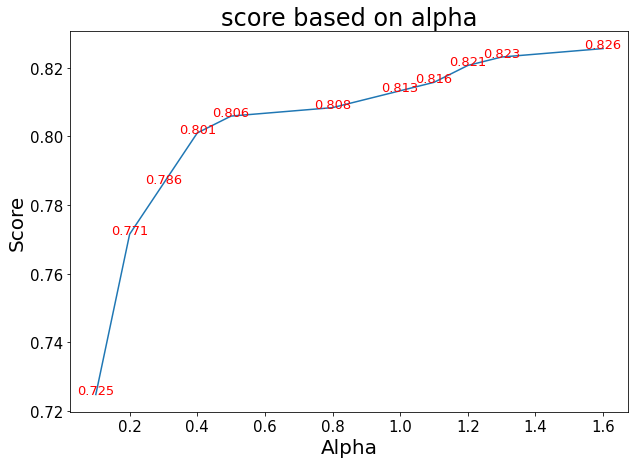

In [79]:
# 그냥 해보는 alpha, score 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(alpha_list, score_list)  # x, y
plt.title("score based on alpha")
plt.xlabel("Alpha")
plt.ylabel("Score")

plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기


for i in range(len(alpha_list)):
    plt.text(alpha_list[i], score_list[i], round(score_list[i], 3),                 # plt.text(x위치, y위치, 표시할 텍스트)
             fontsize = 13, 
             color='red',
             horizontalalignment='center')
plt.show()

In [80]:
# 찾은 alpha값으로 다시 fit
ridge = RidgeClassifier(alpha=1.6)
ridge.fit(X_train_tfidf, y_train)

print("Train score: {:.3f}".format(ridge.score(X_train_tfidf, y_train)))
print("Test score: {:.3f}".format(ridge.score(X_test_tfidf, y_test)))

Train score: 0.948
Test score: 0.739


In [81]:
pip install import_ipynb

In [84]:
# 이전 파일에서 top10_features() 임포트하기
import import_ipynb
from naive_bayes2 import top10_features

top10_features(ridge, tfidf, news_train.target_names)
# 릿지 회귀 결과, 나이브 베이즈보다 훨씬 중요한 단어들을 보여줌

alt.atheism: bobby, religion, atheism, atheists, motto, punishment, islam, deletion, islamic, satan
comp.graphics: graphics, computer, 3d, file, image, hi, 42, using, screen, looking
sci.space: space, orbit, nasa, spacecraft, moon, sci, launch, flight, funding, idea
talk.religion.misc: christian, christians, fbi, blood, order, jesus, objective, children, christ, hudson


## 라쏘 회귀(Lasso regression)
- L1 정규화
- 릿지와 차이점: 특성의 계수가 0에 가까워지면 0으로 바꿈(즉, 해당 특성값 사용X) <br/>
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 이처럼 특성의 수를 줄이는 것을 **특성 선택(feature selection)** 이라고 함

In [89]:
# 라쏘는 로지스틱 회귀분석의 매개변수로 지정

# c는 릿지에서 alpha와 같은 기능, 근데 alpha와 달리 값이 작아야 더 강한 규제
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1)  

lasso.fit(X_train_tfidf, y_train)

print("Train score: {:.3f}".format(lasso.score(X_train_tfidf, y_train)))
print("Test score: {:.3f}".format(lasso.score(X_test_tfidf, y_test)))

Train score: 0.819
Test score: 0.724


In [91]:
# 사용된 특성의 수 출력
print("Used features: {}".format(np.sum(lasso.coef_ != 0)),
     'out of', X_train_tfidf.shape[1])

Used features: 437 out of 2000


In [92]:
top10_features(lasso, tfidf, news_train.target_names)

alt.atheism: bobby, atheism, atheists, islam, religion, islamic, motto, atheist, satan, vice
comp.graphics: graphics, image, 3d, file, computer, hi, video, files, looking, sphere
sci.space: space, orbit, launch, nasa, spacecraft, flight, moon, dc, shuttle, solar
talk.religion.misc: fbi, christian, christians, christ, order, jesus, children, objective, context, blood
